## Load Hourly Weather Data from Open-Meteo (ERA5)

In this section, we will use the **Open-Meteo API** to download historical hourly weather data 
(temperature, precipitation, wind speed, and direction) for a given **latitude**, **longitude**, and **year**.

The data is based on the **ERA5 reanalysis model**, which provides high-quality, 
globally consistent meteorological data.  
The function `load_weather_full()` handles:
- Requesting data from the Open-Meteo archive API  
- Creating a `pandas.DataFrame` with hourly weather variables  
- Indexing the data by timestamp (in local time for *Europe/Oslo*)  


In [480]:

import openmeteo_requests
import pandas as pd
import requests_cache
from retry_requests import retry

import numpy as np

import matplotlib.pyplot as plt

# Create a cached session and enable retrying failed requests
cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

def load_weather_full(lat: float, lon: float, year: int) -> pd.DataFrame:
    """
    Load hourly ERA5 reanalysis weather data from Open-Meteo for the given
    latitude, longitude, and year. The function downloads the following
    variables:
      - temperature_2m (°C)
      - precipitation (mm)
      - wind_speed_10m (m/s)
      - wind_gusts_10m (m/s)
      - wind_direction_10m (degrees)
    and returns them as a pandas DataFrame indexed by UTC timestamps.
    """
    url = "https://archive-api.open-meteo.com/v1/archive"
    start_date = f"{year}-01-01"
    end_date = f"{year}-12-31"

    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start_date,
        "end_date": end_date,
        # Request hourly weather variables
        "hourly": "temperature_2m,precipitation,wind_speed_10m,wind_gusts_10m,wind_direction_10m",
        "timezone": "Europe/Oslo", # Convert timestamps to local time
        "models": "era5" # Use the ERA5 reanalysis model
    }
    # Build the request URL and parameters
    responses = openmeteo.weather_api(url, params=params)
    response = responses[0]
  #  Extract the hourly dataset from the response 
    hourly = response.Hourly()
    time_index = pd.date_range(
        start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
        end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
        freq=pd.Timedelta(seconds=hourly.Interval()),
        inclusive="left"
    )

    # Organize the data into a DataFrame
    variable_names = ["temperature_2m", "precipitation", "wind_speed_10m", "wind_gusts_10m", "wind_direction_10m"]
    data = {"time": time_index}
    for i, name in enumerate(variable_names):
        data[name] = hourly.Variables(i).ValuesAsNumpy()

    df = pd.DataFrame(data)
    df.set_index("time", inplace=True)
    return df

In [484]:
# Bergen coordinates
lat_bergen, lon_bergen = 60.39299, 5.32415
# Load ERA5 weather data for 2019
df_bergen_2019 = load_weather_full(lat_bergen, lon_bergen, 2019)
df_bergen_2019.head()


,temperature_2m,precipitation,wind_speed_10m,wind_gusts_10m,wind_direction_10m
time,,,,,
2018-12-31 23:00:00+00:00,6.70,0.4,42.671768,81.720001,260.776154
2019-01-01 00:00:00+00:00,6.55,0.5,47.959782,87.839996,277.765076
2019-01-01 01:00:00+00:00,6.80,0.9,48.621330,80.279999,296.375275
2019-01-01 02:00:00+00:00,6.85,0.7,52.638840,85.320000,310.006195
2019-01-01 03:00:00+00:00,6.55,0.6,55.753529,98.639999,314.215271


In [177]:
df_bergen_2019.columns

Index(['temperature_2m', 'precipitation', 'wind_speed_10m', 'wind_gusts_10m',
       'wind_direction_10m'],
      dtype='object')

In [179]:
df_bergen_2019.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2018-12-31 23:00:00+00:00 to 2019-12-31 22:00:00+00:00
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   temperature_2m      8760 non-null   float32
 1   precipitation       8760 non-null   float32
 2   wind_speed_10m      8760 non-null   float32
 3   wind_gusts_10m      8760 non-null   float32
 4   wind_direction_10m  8760 non-null   float32
dtypes: float32(5)
memory usage: 239.5 KB


In [181]:
df_bergen_2019.isna().sum()

temperature_2m        0
precipitation         0
wind_speed_10m        0
wind_gusts_10m        0
wind_direction_10m    0
dtype: int64

In [183]:
df_bergen_2019.describe()

,temperature_2m,precipitation,wind_speed_10m,wind_gusts_10m,wind_direction_10m
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,8.846621,0.254053,14.565522,29.391081,186.588120
std,5.089198,0.541051,8.156624,15.241786,101.865685
min,-5.450000,0.000000,0.000000,4.680000,0.674022
25%,4.750000,0.000000,8.373386,17.639999,107.915705
50%,8.050000,0.000000,12.849528,26.280001,164.664124
75%,12.700000,0.300000,19.657119,38.519997,286.471169
max,29.350000,7.300000,55.753529,119.879997,360.000000


In [185]:
df_bergen_2019.to_csv("bergen_2019.csv")

## Outliers and anomalies:

### Setup & Helpers
- Import libraries and set plotting style.
- Define `robust_sigma` using MAD (median absolute deviation).
- Validate that `df_bergen_2019` exists and has `temperature_2m` and `precipitation`.


In [487]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
from sklearn.neighbors import LocalOutlierFactor

# clean seaborn style for plots
plt.style.use("seaborn-v0_8-whitegrid")

# Robust standard deviation using Median Absolute Deviation (MAD)
def robust_sigma(x: np.ndarray) -> float:
    """Compute robust std: sigma ≈ 1.4826 * MAD (0 if MAD==0)."""
    x = np.asarray(x, dtype=float)
    med = np.median(x)
    mad = np.median(np.abs(x - med))
    return 1.4826 * mad if mad > 0 else 0.0

# Data checks / Guards 
# Ensure Bergen 2019 data is loaded
if 'df_bergen_2019' not in globals():
    raise RuntimeError("df_bergen_2019 not found. Load Bergen 2019 first.")

# Ensure required columns exist
for col in ["temperature_2m", "precipitation"]:
    if col not in df_bergen_2019.columns:
        raise RuntimeError(f"Missing column '{col}' in df_bergen_2019. Available: {list(df_bergen_2019.columns)}")


### Temperature Outliers (DCT High-Pass + Robust SPC)
- Build SATV via **DCT high-pass**: zero out the first `k` low-frequency coefficients and inverse DCT.
- Compute **trend** = original − SATV (we do **not** plot SATV).
- Robust SPC bounds from SATV median ± nσ·σ_robust, then map them around the **trend**.
- Plot: temperature, trend, bounds; color outliers.
- Return: (figure, outliers_df, stats_dict).


In [547]:
# Temperature Outliers (DCT High-Pass + Robust SPC)

def temperature_outliers_spc(
    df: pd.DataFrame,
    column: str = "temperature_2m",
    k_cut: int = 24*14,   # remove ~2 weeks of lowest freqs (high-pass)
    n_sigma: float = 3.0,
    title: str | None = None
):
    """
    Detect temperature outliers using DCT high-pass + robust SPC method.

    Steps:
      1) DCT high-pass: remove low-frequency components.
      2) Compute robust SPC bounds on the high-pass residual (SATV).
      3) Identify outliers and visualize results.
    """
    # --- Input validation ---
    if column not in df.columns:
        raise KeyError(f"'{column}' not in dataframe.")

    # --- Prepare signal ---
    s = df[column].astype(float).copy()
    x = s.values
    n = len(x)

    # --- Discrete Cosine Transform (DCT) ---
    c = dct(x, type=2, norm='ortho')

    # High-pass: zero-out first k low-frequency coefficients
    k = int(np.clip(k_cut, 0, n))
    c_hp = c.copy()
    c_hp[:k] = 0.0

    # Reconstruct high-frequency component (SATV = seasonally adjusted temp variation)
    satv = idct(c_hp, type=2, norm='ortho')
    satv = pd.Series(satv, index=s.index, name="satv")

    # --- Compute trend and SPC limits ---
    trend = s - satv  # smooth background (trend)
    trend.name = "trend_dct"

    # Robust sigma using MAD
    med_satv = float(np.median(satv.values))
    sigma = robust_sigma(satv.values) or 1e-12

    satv_up = med_satv + n_sigma * sigma
    satv_lo = med_satv - n_sigma * sigma

    upper = trend + satv_up
    lower = trend + satv_lo
    bounds = pd.DataFrame({"upper_bound": upper, "lower_bound": lower})

    # --- Outlier detection ---
    mask_hi = satv > satv_up
    mask_lo = satv < satv_lo
    mask_out = mask_hi | mask_lo

    z_robust = (satv - med_satv) / sigma
    outliers = pd.DataFrame({
        "original": s[mask_out],
        "trend": trend[mask_out],
        "satv": satv[mask_out],
        "z_robust": z_robust[mask_out],
        "side": np.where(mask_hi[mask_out], "high", "low")
    })
    outliers.index.name = "time"

    # --- Visualization ---
    fig, ax = plt.subplots(figsize=(13, 4.8))
    ax.plot(s.index, s.values, color="#58a6ff", lw=1.0, label="Temperature")
    ax.plot(trend.index, trend.values, color="#f77f00", lw=1.25, label="DCT Trend")
    ax.plot(upper.index, upper.values, color="#a7c957", ls="--", lw=1.1, label=f"+{n_sigma}σ")
    ax.plot(lower.index, lower.values, color="#a7c957", ls="--", lw=1.1, label=f"-{n_sigma}σ")
    if len(outliers):
        ax.scatter(outliers.index, outliers["original"], color="#ff595e", s=18, zorder=5, label="Outliers")

    ax.set_title(title or f"Temperature Outliers — DCT High-Pass (k_cut={k}), ±{n_sigma}σ Robust SPC")
    ax.set_xlabel("Time (UTC)")
    ax.set_ylabel("Temperature (°C)")
    ax.legend(loc="best", ncol=4, fontsize=9)
    plt.tight_layout()

    # --- Summary statistics ---
    stats = {
        "n_points": int(n),
        "n_outliers": int(len(outliers)),
        "pct_outliers": float(100 * len(outliers) / n) if n else 0.0,
        "k_cut": int(k),
        "n_sigma": float(n_sigma),
        "median_satv": float(med_satv),
        "sigma_robust_satv": float(sigma),
    }

    return fig, outliers, stats


### DCT Decomposition (Trend + SATV)

We apply the Discrete Cosine Transform (DCT) to the series and keep only the first `keep_k` coefficients (low-frequency components) to reconstruct the trend.  
Then, we compute the seasonally adjusted temperature variations (SATV) as:  
**SATV = original series − trend**.


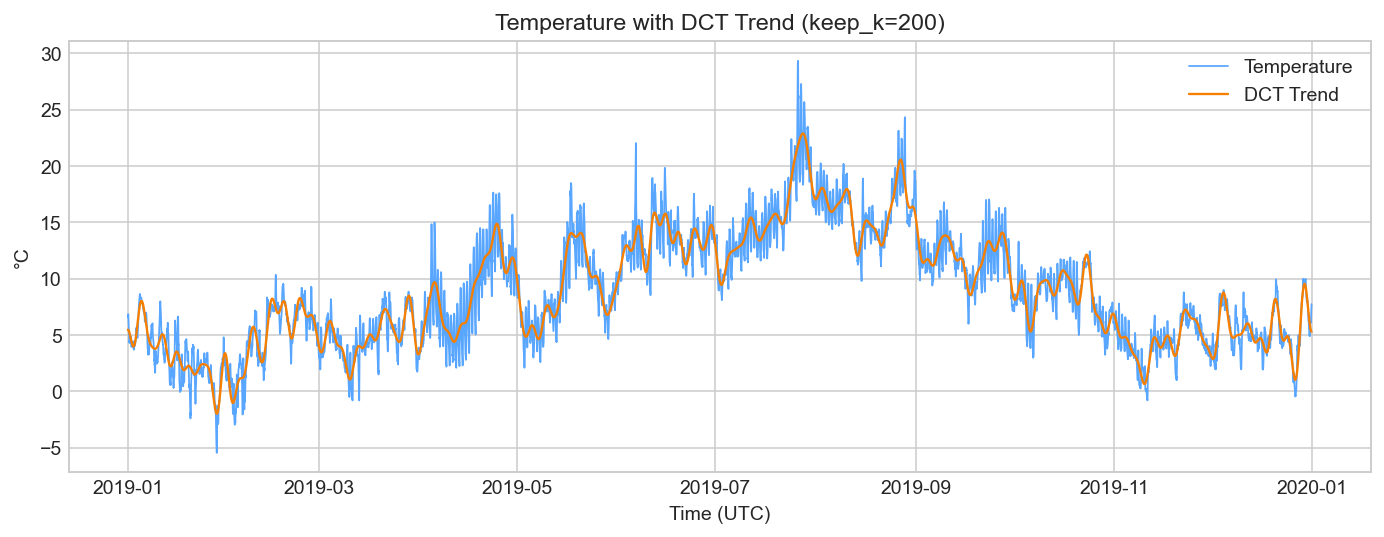

In [549]:
# DCT Decomposition (Trend + SATV)

def dct_decompose_trend_satv(series: pd.Series, keep_k: int = 200):
    """
    Decompose a time series using the Discrete Cosine Transform (DCT).
    - Builds a smooth trend via DCT low-pass filtering (keep_k coefficients).
    - Computes SATV = series - trend (high-frequency variations).
    """
    # Convert to numeric array
    x = series.values.astype(float)

    # Apply DCT (frequency domain)
    coeffs = dct(x, type=2, norm='ortho')

    # Keep only the lowest-frequency components (low-pass)
    coeffs_lp = coeffs.copy()
    keep_k = max(1, min(keep_k, len(coeffs_lp)))
    coeffs_lp[keep_k:] = 0.0

    # Reconstruct trend from truncated coefficients
    trend = idct(coeffs_lp, type=2, norm='ortho')

    # High-frequency component (SATV)
    satv = x - trend

    # Return both as pandas Series
    return (
        pd.Series(trend, index=series.index, name="trend_dct"),
        pd.Series(satv,  index=series.index, name="satv"),
    )


# Apply DCT decomposition to Bergen 2019 temperature data 

temp_series = df_bergen_2019["temperature_2m"].astype(float)

# Decompose into trend and seasonal/adjusted variation (SATV)
trend_dct, satv = dct_decompose_trend_satv(temp_series, keep_k=200)

# Plot the trend against the original data 
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(temp_series.index, temp_series.values, label="Temperature", color="#58a6ff", lw=0.9)
ax.plot(trend_dct.index, trend_dct.values, label="DCT Trend", color="#f77f00", lw=1.2)
ax.set_title("Temperature with DCT Trend (keep_k=200)")
ax.set_xlabel("Time (UTC)")
ax.set_ylabel("°C")
ax.legend()
plt.show()


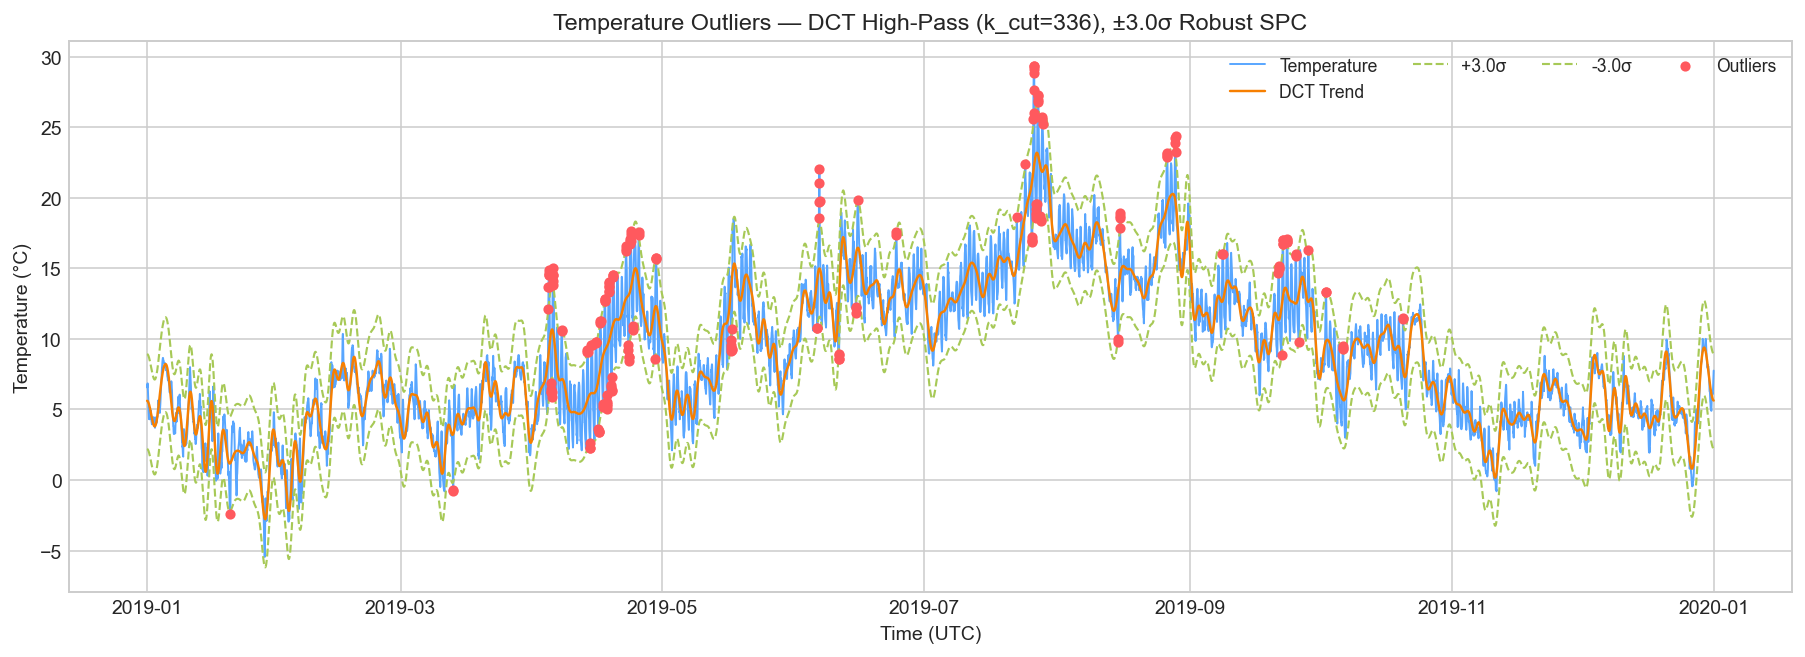

=== Temperature SPC Summary ===
n_points: 8760
n_outliers: 184
pct_outliers: 2.1004566210045663
k_cut: 336
n_sigma: 3.0
median_satv: -0.04757618741787911
sigma_robust_satv: 1.1211285376559683


,original,trend,satv,z_robust,side
time,,,,,
2019-01-20 06:00:00+00:00,-2.4,1.166762,-3.566762,-3.138967,low
2019-03-13 06:00:00+00:00,-0.7,3.243237,-3.943237,-3.474768,low
2019-03-13 07:00:00+00:00,-0.8,3.273836,-4.073836,-3.591256,low


In [551]:
# Test Temperature Function
fig_t, temp_outliers, temp_stats = temperature_outliers_spc(
    df_bergen_2019,
    column="temperature_2m",
    k_cut=24*14,   # remove ~2 weeks of low-freq content (tweak freely)
    n_sigma=3.0
)
plt.show()

print("=== Temperature SPC Summary ===")
for k, v in temp_stats.items():
    print(f"{k}: {v}")
display(temp_outliers.head(3))


### Precipitation Anomalies via LOF
- Use `LocalOutlierFactor` on log1p-transformed precipitation (1D features).
- Parameter `contamination` controls expected anomaly proportion (default 1%).
- Return plot, anomalies dataframe, and summary.


In [554]:
# Precipitation Anomalies via LOF
def precipitation_anomalies_lof(
    df: pd.DataFrame,
    column: str = "precipitation",
    contamination: float = 0.01,
    n_neighbors: int = 24,
    title: str | None = None
):
    """
    Detect precipitation anomalies with LOF using 1D log1p-transformed features.
    """
    if column not in df.columns:
        raise KeyError(f"'{column}' not in dataframe.")

    s = df[column].astype(float).copy()
    # Align & build 1D features
    X = np.log1p(s.values).reshape(-1, 1)

    lof = LocalOutlierFactor(
        n_neighbors=n_neighbors,
        contamination=contamination,
        novelty=False
    )
    y_pred = lof.fit_predict(X)  # -1: anomaly, 1: normal
    is_anom = (y_pred == -1)

    anomalies = pd.DataFrame({
        "value": s[is_anom],
    })
    anomalies.index.name = "time"

    # Plot
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(s.index, s.values, color="#1f77b4", lw=0.9, label="Precipitation (mm)")
    if is_anom.any():
        ax.scatter(s.index[is_anom], s.values[is_anom],
                   color="#d62728", s=18, zorder=5, label="LOF Anomaly")
    ax.set_title(title or f"Precipitation — LOF Anomalies (contamination={contamination:.2%}, n_neighbors={n_neighbors})")
    ax.set_xlabel("Time (UTC)")
    ax.set_ylabel("mm")
    ax.legend(loc="best")
    plt.tight_layout()

    stats = {
        "n_points": int(len(s)),
        "n_anomalies": int(is_anom.sum()),
        "pct_anomalies": float(100 * is_anom.mean()),
        "contamination": float(contamination),
        "n_neighbors": int(n_neighbors),
    }
    return fig, anomalies, stats


### Test LOF Function
- Run `precipitation_anomalies_lof` on Bergen 2019.
- Tune `contamination` (default 0.01) and `n_neighbors` if needed.
- Show plot and a small summary.


C:\Users\Majed\anaconda3\envs\ind320\lib\site-packages\sklearn\neighbors\_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


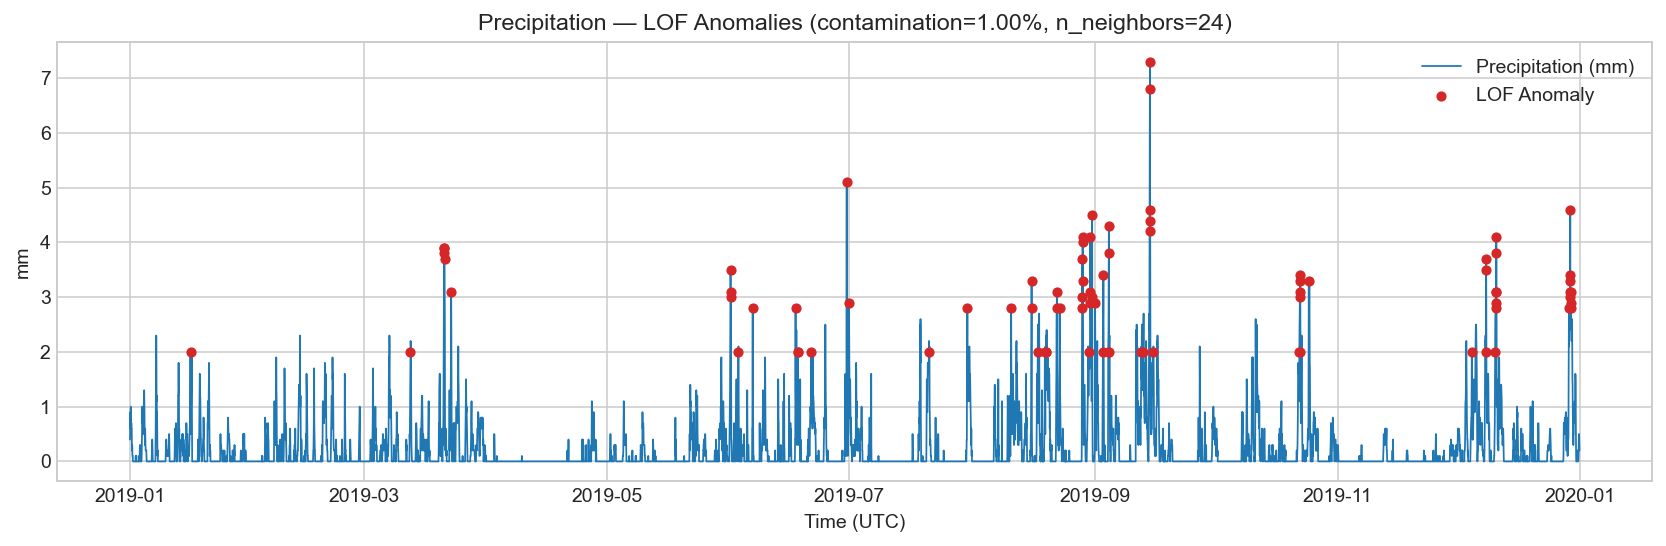

In [557]:
#  Test LOF Function
fig_p, precip_anoms, precip_stats = precipitation_anomalies_lof(
    df_bergen_2019,
    column="precipitation",
    contamination=0.01,
    n_neighbors=24
)
plt.show()



In [558]:
print("=== Precipitation LOF Summary ===")
for k, v in precip_stats.items():
    print(f"{k}: {v}")
display(precip_anoms.head(3))

=== Precipitation LOF Summary ===
n_points: 8760
n_anomalies: 84
pct_anomalies: 0.9589041095890412
contamination: 0.01
n_neighbors: 24


,value
time,
2019-01-16 05:00:00+00:00,2.0
2019-03-12 14:00:00+00:00,2.0
2019-03-21 01:00:00+00:00,3.9


## Seasonal-Trend decomposition using LOESS (STL

🧩 **Quick Background**

**STL (Seasonal-Trend decomposition using LOESS)**  
Decomposes a time series into three components:


y_t = T_t + S_t + R_t


Where:

- **Tₜ**: Trend (long-term direction)  
- **Sₜ**: Seasonal (periodic or cyclic variation)  
- **Rₜ**: Residuals (noise or random fluctuations)


In [563]:
# Setup for STL
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
#  load production data
elhub_df = pd.read_csv("elhub_production.csv")

elhub_df.head(3)

,Unnamed: 0,startTime,endTime,lastUpdatedTime,priceArea,productionGroup,quantityKwh
0,0,2021-01-01 00:00:00+01:00,2021-01-01 01:00:00+01:00,2024-12-20 10:35:40+01:00,NO1,hydro,2507716.8
1,1,2021-01-01 01:00:00+01:00,2021-01-01 02:00:00+01:00,2024-12-20 10:35:40+01:00,NO1,hydro,2494728.0
2,2,2021-01-01 02:00:00+01:00,2021-01-01 03:00:00+01:00,2024-12-20 10:35:40+01:00,NO1,hydro,2486777.5


In [565]:
elhub_df.dtypes

Unnamed: 0           int64
startTime           object
endTime             object
lastUpdatedTime     object
priceArea           object
productionGroup     object
quantityKwh        float64
dtype: object

In [567]:
elhub_df.isnull().sum()

Unnamed: 0         0
startTime          0
endTime            0
lastUpdatedTime    0
priceArea          0
productionGroup    0
quantityKwh        0
dtype: int64

### Function for STL Decomposition

In this step we define the function **`perform_stl_decomposition()`** that:  
1. filters the Elhub production data by **electricity price area** and **production group**,  
2. prepares an **hourly** time series,  
3. performs **STL (Seasonal–Trend decomposition using LOESS)**, and  
4. **plots and returns** the STL decomposition result.



In [581]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

def stl_decompose_simple(
    df,
    area="NO1",                # default area
    production_group="hydro",  # default production type
    period_length=24*7,        # one week for hourly data
    seasonal=25,               # smoother for seasonal pattern
    trend=601,                 # smoother for long-term trend
    robust=True                # reduce the effect of outliers
):
    """
    Simple STL decomposition for Elhub data.

    Parameters
    ----------
    df : DataFrame
        The Elhub dataset.
    area : str
        Electricity price area (e.g. NO1, NO3, NO4).
    production_group : str
        Type of production (e.g. hydro, wind).
    period_length : int
        Length of the seasonal cycle (168 = one week if hourly).
    seasonal : int
        Smoother for the seasonal component.
    trend : int
        Smoother for the trend component.
    robust : bool
        Whether to reduce the effect of outliers.

    Returns
    -------
    fig : plot
        STL decomposition figure.
    result : object
        STL result object.
    """

    # Convert startTime to datetime
    df["startTime"] = pd.to_datetime(df["startTime"], errors="coerce", utc=True)

    # Drop rows with missing or invalid time
    df = df.dropna(subset=["startTime"])

    # Set the time as index and sort it
    df = df.set_index("startTime").sort_index()

    # Filter data by area and production group
    sub = df[(df["priceArea"] == area) & (df["productionGroup"] == production_group)]

    if sub.empty:
        print("No data found for this area or production group.")
        return

    # Prepare the quantity series (energy produced)
    y = pd.to_numeric(sub["quantityKwh"], errors="coerce")
    y = y.resample("h").sum().interpolate()  # hourly, fill missing values

    # Run STL decomposition
    stl = STL(y, period=period_length, seasonal=seasonal, trend=trend, robust=robust)
    result = stl.fit()

    # Plot the decomposition
    fig = result.plot()
    fig.set_size_inches(12, 8)
    fig.suptitle(f"STL Decomposition — {production_group.capitalize()} ({area})", fontsize=14)
    plt.show()

    return fig, result


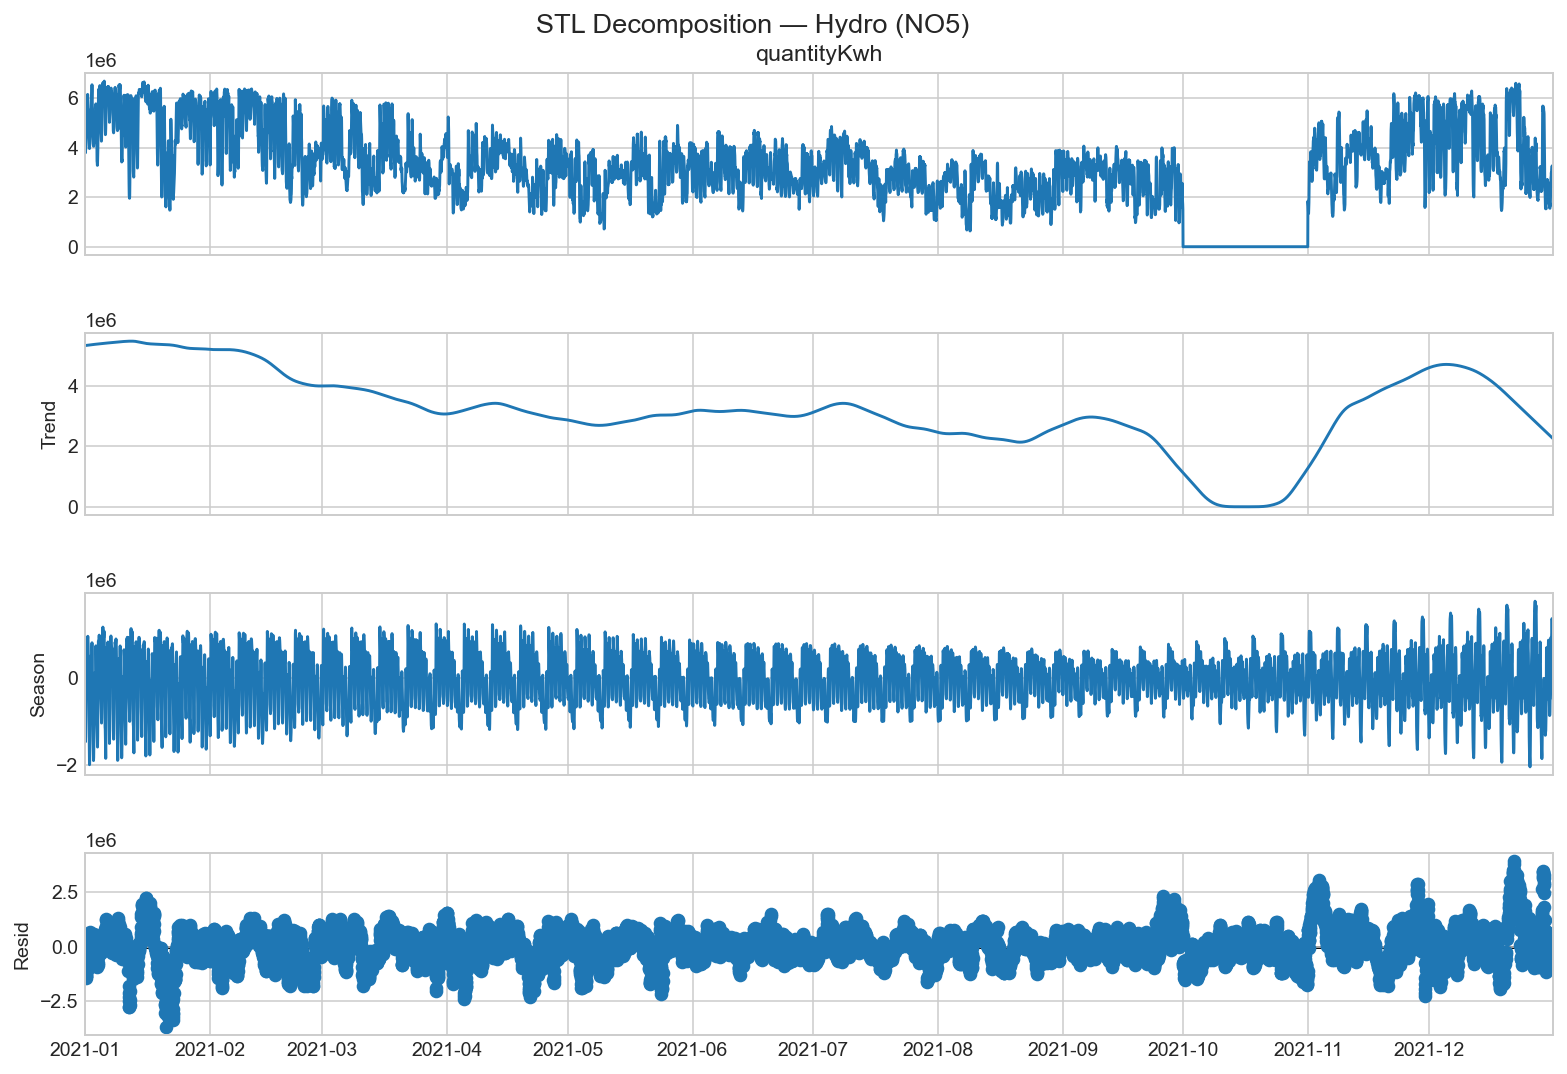

In [580]:
fig, res = stl_decompose_simple(
    elhub_df,
    area="NO5",
    production_group="hydro",
    period_length=24*7,  # one week of hourly data
    seasonal=25,
    trend=601,
    robust=True
)
